# All functions for personality prediction

## Prep

In [18]:
# Import packages

import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('tagsets')
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.util import bigrams, ngrams

import re
import string
from string import punctuation

import sklearn
from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.feature_extraction.text import CountVectorizer 
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif, VarianceThreshold
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_curve

import gensim
from gensim import corpora, models

from empath import Empath

from collections import Counter
from num2words import num2words
from lexicalrichness import LexicalRichness
import textblob


import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.notebook import tqdm
tqdm.pandas()
import datetime
import random
random.seed(32)


[nltk_data] Downloading package punkt to /home/sophia/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/sophia/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/sophia/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package tagsets to /home/sophia/nltk_data...
[nltk_data]   Package tagsets is already up-to-date!


## Prepare dataset

In [2]:
# Import dataset with comments
df = pd.read_csv('/home/sophia/ma_py/pandora_bigfive.csv')

# Import dataset authors and delete not needed columns
authors = pd.read_csv('/home/sophia/ma_py/author_profiles.csv')
bigfive = authors[['author','agreeableness','openness','conscientiousness','extraversion','neuroticism']]
bigfive = bigfive[bigfive['agreeableness'].notna()]
del authors

In [3]:
# Functions

# change language to numeric representation
def numeric_lang(df):
    # change lang to numerical representation
    language = df['lang'].values.tolist()
    language = set(language)
    language
    df['language']= np.select([df.lang == 'en', df.lang == 'es', df.lang == 'nl'], 
                            [0, 1, 2], 
                            default=3)
    # print(gramsdf['language'])
    df = df.drop(columns=['lang'])

    return df

# create time columns from UTC
def create_timecolumns(df):
    readable = []
    weekday = []
    month = []
    year = []
    for row in tqdm(df['created_utc']):
        item = datetime.datetime.fromtimestamp(row)
        weekday_item = item.strftime('%A')
        readable_item = datetime.datetime.fromtimestamp(row).isoformat()
        month.append(str(readable_item[5:7]))
        year.append(str(readable_item[0:4]))
        readable.append(readable_item)
        weekday.append(weekday_item.lower())
    df['time'] = readable
    df['weekday'] = weekday
    df['month'] = month
    df['year'] = year
    return df

# count occurences in time columns to get time distribution
def timecounter(lst, vocablst):
    if vocablst == 'weekday':
        vocab = ['monday', 'tuesday', 'wednesday', 'thursday', 'friday', 'saturday', 'sunday']
    elif vocablst == 'month':
        vocab = ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12']
    elif vocablst == 'year':
        vocab = ['2015', '2016', '2017', '2018', '2019']
    else:
        print("No valid input: vocab list")
    vectorizer = CountVectorizer(analyzer="word", vocabulary=vocab)
    vectors = vectorizer.fit_transform(lst)
    v = vectors.toarray()
    return v

# create a list of all subreddits in the dataset
lst = df['subreddit'].tolist()
lst = [item.lower() for item in lst]
subredditset = set(lst)
subredditlist = list(subredditset)

# count occurences of subreddits 
def subredditcounter(lst, subredditlst):
    vectorizer = CountVectorizer(analyzer="word", vocabulary=subredditlist)
    vectors = vectorizer.fit_transform(lst)
    v = vectors.toarray()
    return v

# aggregate dataset to get one row per author and create new columns for time and subreddit
def create_groupdf(df): 
    print("\tCreate numeric language representation...")
    df = numeric_lang(df)
    print("\tCreate time columns...")
    df = create_timecolumns(df)
    # create dictionary for aggregation function
    d = {'lang': ['nunique'] , 'controversiality': ['mean'], 'gilded': ['mean'], 
         'body': (' '. join), 'doc_body': (lambda x : list(x)),
         'utc': (lambda x : list(x)), 'subreddit': (' '. join), 'num_subreddit': ['nunique'],
         'weekday': (' '. join), 'month': (' '. join), 'year': (' '. join)}
    # '§'. join(x)
 
    # new ungrouped columns
    print("\tCreate new ungrouped columns...")
    df['body'] = df['body'].apply(lambda x: str(x))
    df['doc_body'] = df['body']
    df['num_subreddit'] = df['subreddit']
    df['lang'] = df['language'].apply(lambda x: str(x))
    df['utc'] = df['created_utc'].apply(lambda x: str(x))
#     df['subreddit'] = df['subreddit'].apply(lambda x: [x.lower()])
    df['subreddit'] = df['subreddit'].apply(lambda x: ''.join(x.lower()))
    
    # create df groupd by author + transform
    print("\tGroup df by author...")
    groupdf = df.groupby(['author']).agg(d)
    groupdf = groupdf.reset_index()
    groupdf.columns = groupdf.columns.droplevel(1)
    return groupdf
    
def create_new_columns(df):    
    # body
#     print("\tCreate doc_body...")
# #     df['doc_body'] =  df['doc_body'].apply(lambda x: [x.split("§") for x in x])
#     # created_utc
#     print("\tCreate utc list...")
#     df['all_utc'] = df['utc_lst'].apply(lambda x: x.split())
    # controversiality
    print("\tCreate controversiality column...")
    df['controversiality'] = df['controversiality'].fillna(0)
    # gilded
    print("\tCreate mean_gilded...")
    df['gilded'] = df['gilded'].fillna(0)
    # number of comments per subreddit
    print("\tCreate subreddit_dist...")
    subreddit_predist = subredditcounter(df['subreddit'], subredditlist)
    subreddit_predist = subreddit_predist.tolist()
    df['subreddit_dist'] = subreddit_predist
    # time
    print("\tCreate weekday_dist...")
    weekday = timecounter(df['weekday'], 'weekday')
    weekday = weekday.tolist()
    df['weekday_dist'] = weekday
    print("\tCreate month_dist...")
    month = timecounter(df['month'], 'month')
    month = month.tolist()
    df['month_dist'] = month
    print("\tCreate year_dist...")
    year = timecounter(df['year'], 'year')
    year = year.tolist()
    df['year_dist'] = year
    
    print("\tCreate new aggregated df...")
    newdf = df[['author', 'body', 'doc_body', 'utc', 'controversiality', 
                'gilded', 'num_subreddit', 'subreddit_dist', 'weekday_dist', 
                'month_dist', 'year_dist', 'lang']]
    print("\tSort new aggregated df...")
    newdf = newdf.sort_values(by='author')
    print("\tDrop duplicates in new aggregated df...")
    newdf = newdf.drop_duplicates(subset=['author'])
    return newdf

# get one column for each feature in the distributions of time and subreddit
weekday = ['monday', 'tuesday', 'wednesday', 'thursday', 'friday', 'saturday', 'sunday']
month = ['january', 'february', 'march', 'april', 'may', 'june', 'juli', 'august', 'september', 'october', 'november', 'december']
year = ['2015', '2016', '2017', '2018', '2019']

def onecolumnperdatapoint(df, column, namelist):
    for i in tqdm(range(len(namelist))):
        df[namelist[i]] = df[column].apply(lambda x:[x[i]])
        df[namelist[i]] = [item[0] for item in df[namelist[i]]]
    return df

In [4]:
# Wrapper for commentdf
def create_commentdf(df):
    print("Create new df grouped by author...")
    groupdf = create_groupdf(df)
    print("Create new columns with features...")
    pandora = create_new_columns(groupdf)
    print("Distribute the weekday_dist to several columns...")
    pandora = onecolumnperdatapoint(pandora, 'weekday_dist', weekday)
    print("Distribute the month_dist to several columns")
    pandora = onecolumnperdatapoint(pandora, 'month_dist', month)
    print("Distribute the year_dist to several columns...")
    pandora = onecolumnperdatapoint(pandora, 'year_dist', year)
    print("Distribute the subreddit_dist to several columns...")
    pandora = onecolumnperdatapoint(pandora, 'subreddit_dist', subredditlist)
    print("Drop dist columns...")
    pandora.drop(['weekday_dist', 'month_dist', 'year_dist', 'subreddit_dist'], axis=1, inplace=True)
    return pandora

# create commentdf
print("Create comment df (name: pandora)...")
pandora = create_commentdf(df)
print("Done...")

Create comment df (name: pandora)...
Create new df grouped by author...
	Create numeric language representation...
	Create time columns...


  0%|          | 0/3103208 [00:00<?, ?it/s]

	Create new ungrouped columns...
	Group df by author...
Create new columns with features...
	Create controversiality column...
	Create mean_gilded...
	Create subreddit_dist...
	Create weekday_dist...
	Create month_dist...
	Create year_dist...
	Create new aggregated df...
	Sort new aggregated df...
	Drop duplicates in new aggregated df...
Distribute the weekday_dist to several columns...


  0%|          | 0/7 [00:00<?, ?it/s]

Distribute the month_dist to several columns


  0%|          | 0/12 [00:00<?, ?it/s]

Distribute the year_dist to several columns...


  0%|          | 0/5 [00:00<?, ?it/s]

Distribute the subreddit_dist to several columns...


  0%|          | 0/16063 [00:00<?, ?it/s]

Drop dist columns...
Done...


In [5]:
# merge commentdf and authordf
print("Sort pandora df...")
pandora= pandora.sort_values(by='author')
print("Sort big five df...")
bigfive= bigfive.sort_values(by='author')
if pandora.index.name != 'author':
    print("Set pandora index...")
    pandora = pandora.set_index('author')
if bigfive.index.name != 'author':
    print("Set bigfive index...")
    bigfive = bigfive.set_index('author')
print("Join commentdf and authordf")
pandoradf = pandora.join(bigfive)
# pandoradf = pandoradf.reset_index()

# create binary representation of personality traits
def bigfive_cat(df):
    # change big five to binary representation
    df['agree'] = df['agreeableness'].apply(lambda x: 0 if x<50 else 1)
    df['openn'] = df['openness'].apply(lambda x: 0 if x<50 else 1)
    df['consc'] = df['conscientiousness'].apply(lambda x: 0 if x<50 else 1)
    df['extra'] = df['extraversion'].apply(lambda x: 0 if x<50 else 1)
    df['neuro'] = df['neuroticism'].apply(lambda x: 0 if x<50 else 1)
    return df

print("Create binary representations for each personality trait")
pandoradf = bigfive_cat(pandoradf)
pandoradf

Sort pandora df...
Sort big five df...
Set pandora index...
Set bigfive index...
Join commentdf and authordf
Create binary representations for each personality trait


,body,doc_body,utc,controversiality,gilded,num_subreddit,lang,monday,tuesday,wednesday,...,dancedancerevolution,agreeableness,openness,conscientiousness,extraversion,neuroticism,agree,openn,consc,extra
author,,,,,,,,,,,,,,,,,,,,,
-Areopagan-,Your first and second question is the same que...,[Your first and second question is the same qu...,"[1513882848, 1513744846, 1522253427, 151370438...",0.000000,0.000000,1,1,0,0,2,...,0,0.0,99.0,96.0,60.0,1.0,0,1,1,1
-BigSexy-,I've been asked to cum everywhere with my ex j...,[I've been asked to cum everywhere with my ex ...,"[1507650565, 1516397088, 1502590403, 151682490...",0.020737,0.000000,147,4,359,0,444,...,0,39.0,92.0,1.0,18.0,4.0,0,1,0,0
-BlitzN9ne,I'm currently in the middle of making a Payday...,[I'm currently in the middle of making a Payda...,"[1422166355, 1423504286, 1449881503, 145521567...",0.014159,0.000000,116,4,393,0,343,...,0,50.0,85.0,15.0,50.0,30.0,1,1,0,1
-CrestiaBell,First and foremost I extend my condolences to ...,[First and foremost I extend my condolences to...,"[1462304635, 1528773104, 1513663029, 148131600...",0.017687,0.000866,149,4,1258,0,1210,...,0,50.0,85.0,50.0,85.0,50.0,1,1,1,1
-dyad-,I failed both...I'm great at reading people ir...,[I failed both...I'm great at reading people i...,"[1475875524, 1473096864, 1505168466, 150318014...",0.000000,0.000000,5,2,25,0,40,...,0,60.0,67.0,45.0,10.0,47.0,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
zugzwang_03,You know that giggly group of women going to t...,[You know that giggly group of women going to ...,"[1466099531, 1469625145, 1455352713, 150837533...",0.011709,0.000291,146,3,2409,0,2317,...,0,10.0,41.0,86.0,83.0,18.0,0,0,1,1
zuluthrone,"I saw some speculate that the ""download"" would...","[I saw some speculate that the ""download"" woul...","[1438979642, 1451195516, 1468833505, 151331960...",0.018458,0.000000,46,3,119,0,142,...,0,17.0,96.0,28.0,95.0,34.0,0,1,0,1
zwelg,I am actually pretty pleased about my score:Ag...,[I am actually pretty pleased about my score:A...,[1508185843],0.000000,0.000000,1,1,1,0,0,...,0,39.0,89.0,91.0,80.0,3.0,0,1,1,1


## Preprocessing

In [6]:
# Functions

# define stopwordlist to use
def choose_stopwordlist(df, mode):
    if mode == 'NLTK':
        stopwordList = stopwords.words('english')
    if mode == 'NLTK-neg':
        stopwordList = stopwords.words('english')
        stopwordList.remove('no')
        stopwordList.remove('nor')
        stopwordList.remove('not')
    return stopwordList

# remove decontractions
def decontracted(phrase):
    # specific
    phrase = re.sub(r"won\'t", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)
    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

# create sentence tokens
def senttokenize(df):
    sentbody = []
    for row in tqdm(df['doc_body']):
        sentitem = []
        for item in row:
            sentences = sent_tokenize(item)
            sentitem.append(sentences)
        sentbody.append(sentitem)
    df['senttokens'] = sentbody
    return df

# lower words and remove special characters
def lower_special(df):
    newrow = []
    for row in tqdm(df['probody']):
        newcomment = []
        for comment in row:
            text_pre = ""
            for character in comment:
                if character.isalnum() or character.isspace():
                    character = character.lower()
                    text_pre += character
                else:
                    text_pre += " "
            newcomment.append(text_pre)
        newrow.append(newcomment)   
    df['probody'] = newrow
    return df

# remove stopwords
def remove_stopwords(df, stopwordList):
    newprobody = []
    for row in tqdm(df['probody']):
        newrowprobody = []
        for comment in row:
            words = [word for word in comment.split() if (word not in stopwordList)]
            newcomment = ' '.join(words)
            newrowprobody.append(newcomment)
        newprobody.append(newrowprobody)
    df['probody'] = newprobody
    return df

# change numbers to words and tokenize words

import decimal
def num_tokenize(df):    
    newbody_complete = []
    newprobody_complete = []
    # num2words
    for row in tqdm(df['probody']):
        newbody = []
        newprobody = []
        for sentence in row:
            # string to list
            inputtext = sentence.split()
            numlist = []
            for i in range(len(inputtext)):
                if inputtext[i].isnumeric():
                    numlist.append(i)
            for number in numlist:
                # deleted: fractions, superscripts, extremely large numbers, 卌卌, 一
                try:
                    inputtext[number] = num2words(inputtext[number])
                except decimal.InvalidOperation:
                    inputtext[number] = " "
                except OverflowError:
                    inputtext[number] = " "

            # list to string
            inputtext = [word for word in inputtext if word.isalpha()]
            celltext = ' '.join(inputtext)
            newprobody.append(celltext)
            # tokenize
            words = word_tokenize(celltext)
            newbody.append(words)
        newbody_complete.append(newbody)
        newprobody_complete.append(newprobody)
    df['probody'] = newprobody_complete
    df['tokens'] = newbody_complete
    return df

# Porter Stemmer
def stemming(df):
    ps = PorterStemmer()
    for row in tqdm(df['tokens']):
        for comment in row:
            words = [ps.stem(word) for word in comment]
            comment = ' '.join(words)
    return df

# bring columns of dataframe in correct order
def ordering(df):
    cols_tomove = ['body', 'doc_body', 'probody', 'tokens', 'senttokens', 'agreeableness', 'openness', 'conscientiousness', 'extraversion', 'neuroticism', 'agree', 'openn', 'consc', 'extra', 'neuro']
    orderdf  = df[cols_tomove + [col for col in df.columns if col not in cols_tomove]]
    return orderdf

In [7]:
# Wrapper

def preprocess(df):
    # adjust some column representations
    df = bigfive_cat(df)
    # choose stopwordlist with or without negation
    stopwordList = choose_stopwordlist(df, mode='NLTK-neg')
    # decontract abbreviations (e.g., n't to not)
    print("Decontract...")
    df['probody'] = df['doc_body'].apply(lambda x:([decontracted(x) for x in x]))
    # create sentence tokens
    print("Tokenize Sentences...")
    df = senttokenize(df)
    # lower, remove stopwords, num2words, tokenize
    print("Lower words and remove special characters...")
    df = lower_special(df)
    print("Remove stopwords...")
    df = remove_stopwords(df, stopwordList)
    print("Change numbers to words and tokenize words...")
    df = num_tokenize(df)
    # porters stemmer
    print("Porters Stemmer...")
    df = stemming(df)
    print("Order df...")
    df = ordering(df)
    print("Done!")
    return df

# apply preprocessing
predf = preprocess(pandoradf)
predf.to_pickle("preprocessed_df_allcomments.pkl")
predf

Decontract...
Tokenize Sentences...


  0%|          | 0/1606 [00:00<?, ?it/s]

Lower words and remove special characters...


  0%|          | 0/1606 [00:00<?, ?it/s]

Remove stopwords...


  0%|          | 0/1606 [00:00<?, ?it/s]

Change numbers to words and tokenize words...


  0%|          | 0/1606 [00:00<?, ?it/s]

Porters Stemmer...


  0%|          | 0/1606 [00:00<?, ?it/s]

Order df...
Done!


,body,doc_body,probody,tokens,senttokens,agreeableness,openness,conscientiousness,extraversion,neuroticism,...,transportfever,socialistprogrammers,suicidology,dixiefood,worldproblems,xcxheads,speedrunnersgame,hypnobeach,create_your_circle,dancedancerevolution
author,,,,,,,,,,,,,,,,,,,,,
-Areopagan-,Your first and second question is the same que...,[Your first and second question is the same qu...,[first second question question try make incis...,"[[first, second, question, question, try, make...",[[Your first and second question is the same q...,0.0,99.0,96.0,60.0,1.0,...,0,0,0,0,0,0,0,0,0,0
-BigSexy-,I've been asked to cum everywhere with my ex j...,[I've been asked to cum everywhere with my ex ...,[asked cum everywhere ex experiment preferred ...,"[[asked, cum, everywhere, ex, experiment, pref...",[[I've been asked to cum everywhere with my ex...,39.0,92.0,1.0,18.0,4.0,...,0,0,0,0,0,0,0,0,0,0
-BlitzN9ne,I'm currently in the middle of making a Payday...,[I'm currently in the middle of making a Payda...,[currently middle making payday two inspired m...,"[[currently, middle, making, payday, two, insp...",[[I'm currently in the middle of making a Payd...,50.0,85.0,15.0,50.0,30.0,...,0,0,0,0,0,0,0,0,0,0
-CrestiaBell,First and foremost I extend my condolences to ...,[First and foremost I extend my condolences to...,[first foremost extend condolences family espe...,"[[first, foremost, extend, condolences, family...",[[First and foremost I extend my condolences t...,50.0,85.0,50.0,85.0,50.0,...,0,0,0,0,0,0,0,0,0,0
-dyad-,I failed both...I'm great at reading people ir...,[I failed both...I'm great at reading people i...,"[failed great reading people irl swear haha, i...","[[failed, great, reading, people, irl, swear, ...",[[I failed both...I'm great at reading people ...,60.0,67.0,45.0,10.0,47.0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
zugzwang_03,You know that giggly group of women going to t...,[You know that giggly group of women going to ...,[know giggly group women going bar go dance sa...,"[[know, giggly, group, women, going, bar, go, ...",[[You know that giggly group of women going to...,10.0,41.0,86.0,83.0,18.0,...,0,0,0,0,0,0,0,0,0,0
zuluthrone,"I saw some speculate that the ""download"" would...","[I saw some speculate that the ""download"" woul...",[saw speculate download would backup rather st...,"[[saw, speculate, download, would, backup, rat...","[[I saw some speculate that the ""download"" wou...",17.0,96.0,28.0,95.0,34.0,...,0,0,0,0,0,0,0,0,0,0
zwelg,I am actually pretty pleased about my score:Ag...,[I am actually pretty pleased about my score:A...,[actually pretty pleased score agreeableness m...,"[[actually, pretty, pleased, score, agreeablen...",[[I am actually pretty pleased about my score:...,39.0,89.0,91.0,80.0,3.0,...,0,0,0,0,0,0,0,0,0,0


## Extract features

In [8]:
# User features

# Preprocessing for LDA
def preprocess_lda(df):
    neglst = ["no", "not", "none", "nobody", "nothing", "neither", "nowhere", "never", "nay"]
    inputlst = []
    for row in tqdm(df['tokens']):
        rowlst = []
        for comment in row:
            rowlst.append([word for word in comment if (word not in neglst)])
        inputlst.append(rowlst)
    return inputlst
# LDA for topics
def apply_lda(df, inputlst, number, name):
    print("Start LDA...")
    lst = []
    for row in tqdm(inputlst):
        if len(row) < 2:
            lst.append(-1)
        else:
            dictionary = corpora.Dictionary(row)
            corpus = [dictionary.doc2bow(text) for text in row]
            ldamodel = gensim.models.LdaMulticore(corpus, num_topics=number, id2word = dictionary, passes=20, workers=15)
            result = ldamodel.print_topics(num_topics=1, num_words=1)
            res = list(result)
            topic = [item[0] for item in res]
            lst.append(topic[0])
    df[name] = lst
    return df

# Wrapper
def extract_userfeatures(df):
    print("Preprocessing for LDA...")
    inputlst = preprocess_lda(df)
    print("LDA with fifty topics: ")
    df = apply_lda(df, inputlst, 50, "ldafifty")
    print("LDA with onehundred topics: ")
    df = apply_lda(df, inputlst, 100, "ldahundred")
    return df

# create df with user features
# user_feat_df = extract_userfeatures(predf)
# user_feat_df.to_pickle("user_feat_df_allcomments.pkl")

In [19]:
# Linguistic features (functions)

# other features that are not mentioned in the paper
def create_features(df):
#     df['char_count'] = df['body']
#     df['stopwords'] = df['body']
#     df['total_punc'] = df['body']
#     df['total_num'] = df['body']
#     df['total_uppercase'] = df['body']
#     d = {'char_count': (lambda x : str.len()) , 
#          'stopwords': (lambda x: len([x for x in x.split() if x in stopwordList])), 
#          'total_punc': (lambda x: len([x for x in x.split() for j in x if j in string.punctuation])), 
#          'total_num': (lambda x: len([x for x in x.split() if x.isdigit()])), 
#          'total_uppercase': (lambda x: len([x for x in x.split() if x.isupper()]))}

#     groupdf = df.groupby(['author']).agg(d)
#     groupdf = groupdf.reset_index()
#     groupdf.columns = groupdf.columns.droplevel(1)
    
    # Total number of characters (including space)
    print("\tCharacter count per author...")
    df['char_count'] = df['body'].str.len()
    # Total number of stopwords
    print("\tNumber of stopwords per author...")
    stopwordList = stopwords.words('english')
    df['stopwords'] = df['body'].apply(lambda x: len([x for x in x.split() if x in stopwordList]))
    # Total number of punctuation or special characters
    print("\tTotal number of punctuation per author...")
    df['total_punc'] = df['body'].apply(lambda x: len([x for x in x.split() for j in x if j in string.punctuation]))
    # Total number of numerics
    print("\tTotal number of numerics per author...")
    df['total_num'] = df['body'].apply(lambda x: len([x for x in x.split() if x.isdigit()]))
    # Total number of uppercase words
    print("\tTotal number of upper case words per author...")
    df['total_uppercase'] = df['body'].apply(lambda x: len([x for x in x.split() if x.isupper()]))    
    return df

# type token ratio
def typetokenratio(df):
    ratiolst = []
    for comment in tqdm(df['body']):
            lex = LexicalRichness(comment)
            if lex.words == 0:
                ratiolst.append(0)
            else:
                ratio = lex.ttr
                ratiolst.append(ratio)
    df['ttr'] = ratiolst
    return df

# words per sentence
def wordcounter(df):
    lengthscore = []
    for row in tqdm(df['senttokens']):
        rowscore = []
        for comment in row:
            sentencescore = 0
            for senttoken in comment:
                length = len(senttoken.split())
                sentencescore += length
            if len(comment) > 1:
                sentencescore = sentencescore/len(comment)
        lengthscore.append(sentencescore)
        arr = np.array(lengthscore)
    df['words_per_sent'] = lengthscore
    return df

# words longer than six characters
def charcounter(df):
    charscore = []
    for row in tqdm(df['tokens']):
        for comment in row:
            rowcharscore = 0
            lencomment = len(comment)
            if lencomment == 0:
                score = 0
            else:
                number = 0
                for token in comment:
                    length = len(token)
                    if length > 5:
                        number+=1
                score = number/lencomment
            rowcharscore += score
        rowcharscore = rowcharscore/len(row)
        charscore.append(rowcharscore)
    df['wordslongersix'] = charscore
    return df

# POS tagger
def tagging(df):
    past = [] #VPA
    presence = [] #VPR
    adverbs = [] #RB
    prepositions = [] #PREP
    pronouns = [] #PR
    for comment in tqdm(df['body']):
            text = comment.split()
            tags = nltk.pos_tag(text)
            counts = Counter(tag for word,tag in tags)
            total = sum(counts.values())
            pron = counts['PRP'] + counts['PRP$']
            verbspr = counts['VB'] + counts['VBG'] + counts['VBP'] + counts['VBZ'] + counts['MD']
            verbspa = counts['VBD'] + counts['VBN']
            preps = counts['IN'] + counts['TO']
            counts['PR'] = pron
            counts['PREP'] = preps
            counts['VPR'] = verbspr #present tense
            counts['VPA'] = verbspa #past tense
            if total == 0:
                allcounts = dict((word, float(count)/1) for word,count in counts.items())
            else:
                allcounts = dict((word, float(count)/total) for word,count in counts.items())
            try:
                past.append(allcounts['VPA'])
            except KeyError:
                past.append(0)
            try:
                presence.append(allcounts['VPR'])
            except KeyError:
                presence.append(0)
            try:
                adverbs.append(allcounts['RB'])
            except KeyError:
                adverbs.append(0)
            try:
                prepositions.append(allcounts['PREP'])
            except KeyError:
                prepositions.append(0)
            try:
                pronouns.append(allcounts['PR'])
            except KeyError:
                pronouns.append(0)
    df['pasttense'] = past
    df['presencetense'] = presence
    df['adverbs'] = adverbs
    df['prepositions'] = prepositions
    df['pronouns'] = pronouns
    return df

def ngrams(df, n_min, n_max, ngramtype):
    # convert input from list to string
    ngrams = []
    inputtext = []
    for row in tqdm(df['tokens']):
        for comment in row:
            text = ' '.join(comment)
        inputtext.append(text)
    print("Length of inputtext: ", len(inputtext))
    vectorizer = TfidfVectorizer(ngram_range=(n_min,n_max), analyzer=ngramtype)
    print("Vectorize...")
    vectors = vectorizer.fit_transform(tqdm(inputtext))
    dense = vectors.todense()
    denselist = dense.tolist()
    print("Get feature names...")
    names = vectorizer.get_feature_names()
    print("Length of feature names: ", len(names))
    print("Create df...")
    ngramdf = pd.DataFrame(denselist, columns=names)
#     ngramdf['author'] = df['author']
    return ngramdf

def merge_dfs(df1, df2, df3):
#     cwngramsdf = pd.merge(df1, df2, on='author', how='inner', suffixes= (None, "_charngram"))
#     gramsdf = pd.merge(df3, cwngramsdf, on='author', how='inner', suffixes= (None, "_ngram"))
    ngramsdf = df1.join(df2, rsuffix="_char")
    newdf = df3.join(ngramsdf, rsuffix="_ngram")
    return newdf

In [20]:
# Wrapper for linguistic features
# def new_lin_columns(df):
#     print("Create additional features...")
#     df = create_features(df)
#     return df

# lin_extra_df = new_lin_columns(predf)
# lin_extra_df.to_pickle("lin_extra_df_withoutuserfeat_allcomments.pkl")


def extract_lin_features(df, create_ngrams):
    print("Create additional features...")
    df = create_features(df)
    print("Create ttr...")
    df = typetokenratio(df)
    print("Count words per sentence...")
    df = wordcounter(df)
    print("Count words with more than six letters...")
    df = charcounter(df)
    print("POS-Tagger...")
    df = tagging(df)
    print("number of rows df", len(df))
    
    if create_ngrams == "none":
        return df
    
    elif create_ngrams == "all":
        print("Ngrams...")
        print("Create word ngrams...")
        wordngramsdf = ngrams(df, 1, 3, "word")
        print("Create char ngrams...")
        charngramsdf = ngrams(df, 2, 3, "char")
        print("Merge df...")
        gramsdf = merge_dfs(wordngramsdf, charngramsdf, df)
        return gramsdf
    
    elif create_ngrams == "word":
        wordngrams = ngrams(df, 1, 3, 'word')
        wordngramsdf = pd.DataFrame(wordngrams)
#         gramsdf = pd.merge(df, wordngramsdf, on='author', how='inner', suffixes=(None, "_ngram"))
        gramsdf = df.join(wordngramsdf)
        return gramsdf
    
# create dataframe with linguistic features

# without ngrams
# lin_feat_df = extract_lin_features(user_feat_df, "none")

# with all ngrams
# lin_ngrams_df = extract_lin_features(user_feat_df, "all")ii

lin_ngrams_df = extract_lin_features(predf, "all")
lin_ngrams_df.to_pickle("lin_feat_df_withoutuserfeat_allcomments.pkl")

# wordngrams only
# lin_wordngrams_df = extract_lin_features(user_feat_df, "word")

Create additional features...
	Character count per author...
	Number of stopwords per author...
	Total number of punctuation per author...
	Total number of numerics per author...
	Total number of upper case words per author...
Create ttr...


  0%|          | 0/1606 [00:00<?, ?it/s]

Count words per sentence...


  0%|          | 0/1606 [00:00<?, ?it/s]

Count words with more than six letters...


  0%|          | 0/1606 [00:00<?, ?it/s]

POS-Tagger...


  0%|          | 0/1606 [00:00<?, ?it/s]

number of rows df 1606
Ngrams...
Create word ngrams...


  0%|          | 0/1606 [00:00<?, ?it/s]

Length of inputtext:  1606
Vectorize...


  0%|          | 0/1606 [00:00<?, ?it/s]

Get feature names...
Length of feature names:  80192
Create df...
Create char ngrams...


  0%|          | 0/1606 [00:00<?, ?it/s]

Length of inputtext:  1606
Vectorize...


  0%|          | 0/1606 [00:00<?, ?it/s]

Get feature names...
Length of feature names:  7521
Create df...
Merge df...


In [25]:
# Wordlists (functions)

# Empath
# create new categories with empath
def new_cat():
    empath = Empath()
    social = empath.create_category("social",["mate","talk","they"])
    humans = empath.create_category("humans",["adult","baby","boy"])
    cognitive = empath.create_category("cognitive",["cause","know","ought"])
    insight = empath.create_category("insight",["think","know","consider"])
    causation = empath.create_category("causation",["because","effect","hence"])
    discrepancy = empath.create_category("discrepancy",["should","would","could"])
    tentative = empath.create_category("tentative",["maybe","perhaps","guess"])
    certainty = empath.create_category("certainty",["always","never", "proof"])
    inhibition = empath.create_category("inhibition",["block","constrain","stop"])
    inclusive = empath.create_category("inclusive",["and","with","include"])
    exclusive = empath.create_category("exclusive",["but","without","exclude"])
    perceptual = empath.create_category("perceptual",["observing","hear","feeling"])
    see = empath.create_category("see",["view","saw","seen"])
    feel = empath.create_category("feel",["feels","touch","feeling"])
    biological = empath.create_category("biological",["eat","blood","pain"])
    relativity = empath.create_category("relativity",["area","bend","go"])
    space = empath.create_category("space",["down","in","thin"])
    time = empath.create_category("time",["end","until","season"])
    agreement = empath.create_category("agreement", ["agree", "ok", "yes"])
    fillers = empath.create_category("fillers", ["like", "Imean", "yaknow"])
    nonfluencies = empath.create_category("nonfluencies", ["umm", "hm", "er"])
    conjunctions = empath.create_category("conjunctions", ["and", "but", "whereas"])
    quantifiers = empath.create_category("quantifiers", ["few", "many", "much"])
    numbers = empath.create_category("numbers", ["two", "fourteen", "thousand"])

def apply_empath(df):
    empath = Empath()
    print("Create new empath categories...")
    new_cat()
    print("Apply empath...")
    empathvalues = []
    empathcategories = ["swearing_terms", "social", "family", "friends", "humans", "emotional", "positive_emotion", "negative_emotion", "fear", "anger", "sadness", "cognitive", "insight", "causation", "discrepancy", "tentative", "certainty", "inhibition", "inclusive", "exclusive", "perceptual", "see", "hear", "feel", "biological", "body", "health", "sexual", "eat", "relativity", "space", "time", "work", "achievement", "leisure", "home", "money", "religion", "death" ,"agreement", "fillers", "nonfluencies"]
    for sentence in tqdm(df['body']):
        empathvalues.append(empath.analyze(sentence, categories=empathcategories, normalize=True))
    empathdf = pd.DataFrame(empathvalues)
#     empathdf['author'] = df['author']

#     newdf = pd.merge(df, empathdf, on='author', how='inner', suffixes=(None, "_wordlist"))
    newdf = df.join(empathdf, rsuffix="_empath")
    return newdf

In [26]:
# Import data for other wordlists
concretenessdf = pd.read_csv('/home/sophia/ma_py/psych_lists/concreteness.csv')
cdf = concretenessdf[['Conc.M']]
cmatrix = cdf.to_numpy()
concrete = concretenessdf['Word'].values.tolist()

happinessdf = pd.read_csv('/home/sophia/ma_py/psych_lists/happiness_ratings.csv')
hdf = happinessdf[['happiness_average']]
hmatrix = hdf.to_numpy()
happiness = happinessdf['word'].values.tolist()

cursedf = pd.read_csv('/home/sophia/ma_py/psych_lists/mean_good_curse.csv')
cudf = cursedf[['mean_good_curse']]
cumatrix = cudf.to_numpy()
curse = cursedf['word'].values.tolist()

sensorydf = pd.read_csv('/home/sophia/ma_py/psych_lists/sensory_experience_ratings.csv')
serdf = sensorydf[['Average SER']]
sermatrix = serdf.to_numpy()
ser = sensorydf['Word'].values.tolist()

alldf = pd.read_csv('/home/sophia/ma_py/psych_lists/sensory_ratings_all.csv')
newalldf = alldf[['Emotion', 'Polarity', 'Social', 'Moral', 'MotionSelf', 'Thought', 'Color', 'TasteSmell', 'Tactile', 'VisualForm', 'Auditory', 'Space', 'Quantity', 'Time', 'CNC', 'IMG', 'FAM']]
allmatrix = newalldf.to_numpy()
allsens = alldf['Word'].values.tolist()

valarodomdf = pd.read_csv('/home/sophia/ma_py/psych_lists/valence_arousal_dominence.csv')
vaddf = valarodomdf[['V.Mean.Sum', 'A.Mean.Sum', 'D.Mean.Sum']]
vadmatrix = vaddf.to_numpy()
vad = valarodomdf['Word'].values.tolist()

mrcdf = pd.read_csv('/home/sophia/ma_py/psych_lists/mrclists_c_p.csv', sep='\t', names=['word', 'cmean', 'pmean'])
cpdf = mrcdf[['cmean', 'pmean']]
cpmatrix = cpdf.to_numpy()
mrc = mrcdf['word'].values.tolist()

# function for other wordlists

def counter(df, vocab):
    inputtext = []
    for row in tqdm(df['body']):
        text = ' '.join(row)
        inputtext.append(text)
    vectorizer = CountVectorizer(analyzer="word", ngram_range=(1,1), vocabulary = vocab)
    print("Vectorize...")
    vectors = vectorizer.fit_transform(tqdm(inputtext))
    v = vectors.toarray()
    return v

def multiply(matrix, ratings):
    # matrix multiplication 
    result = np.matmul(matrix, ratings)
    # divide each score with the number of words in the list to normalize
    if len(ratings) > 0:
        result = result/(len(ratings))
    return result

def aggregator(df, vocab, ratings, name):
    print("\tCount...")
    count = counter(df, vocab)
    print("\tMultiply...")
    result = multiply(count, ratings)
    num_rows, num_cols = result.shape
    
    if num_cols ==1:
        df[name] = result
    else:
        resultdf = pd.DataFrame(result)
        for i in range(len(name)):
            # first i is zero
            column = name[i]
            df[column] = resultdf[i]
    return df

In [29]:
# wordlists created manually

negations = ["no", "not", "none", "nobody", "nothing", "neither", "nowhere", "never", "nay"]
articles = ["a", "an", "the"]
future = ["will", "gonna"]

def list_counter(df, vocab, name):
    inputtext = []
    total = []
    for row in tqdm(df['body']):
        total.append(len(row))
        text = ' '.join(row)
        inputtext.append(text)
    vectorizer = CountVectorizer(analyzer="word", ngram_range=(1,1), vocabulary = vocab)
    print("\tVectorize...")
    vectors = vectorizer.fit_transform(tqdm(inputtext))
    v = vectors.toarray()
    averagev = v.sum(axis=1)
    totalvector =  np.array(total)
    score = np.divide(averagev, totalvector)
    df[name] = score
    return df

In [30]:
# Wrapper for wordlists

def extract_wordlist_features(df):
    print("Empath...")
    empdf = apply_empath(df)
    # create scores for each word list and add them to df
    print("Count Wordlist Concreteness: \n")
    psychdf = aggregator(empdf, concrete, cmatrix, "concreteness")
    print("Count Wordlist Happiness: \n")
    psychdf = aggregator(empdf, happiness, hmatrix, "happiness")
    print("Count Wordlist Good_Curse: \n")
    psychdf = aggregator(empdf, curse, cumatrix, "good_curse")
    print("Count 17 further wordlists: \n")
    psychdf = aggregator(empdf, allsens, allmatrix, ['emotion', 'polarity', 'social', 'moral', 'motionself', 'thought', 'color', 'tastesmell', 'tactile', 'visualform', 'auditory', 'space', 'quantity', 'time', 'CNC', 'IMG', 'FAM'])
    print("Count Wordlist SER: \n")
    psychdf = aggregator(empdf, ser, sermatrix, "SER")
    print("Count Wordlists Valence, Arousal, Dominance: \n")
    psychdf = aggregator(empdf, vad, vadmatrix, ['valence', 'arousal', 'dominance'])
    print("Count Wordlist Negation: \n")
    psychdf = list_counter(empdf, negations, "negations")
    print("Count Wordlist Articles: \n")
    psychdf = list_counter(empdf, articles, "articles")
    print("Count Wordlist Future: \n")
    psychdf = list_counter(empdf, future, "future")
    print("Count Wordlists from MRC (2): \n")
    psychdf = aggregator(empdf, mrc, cpmatrix, ["mrc_cmean", "mrc_pmean"])
    
    return psychdf

psychdf = extract_wordlist_features(lin_ngrams_df)
psychdf.to_pickle("wordlists_lin_feat_df_withoutuserfeat_allcomments.pkl")

Empath...
Create new empath categories...
["talk", "mates", "mate", "Because", "friends", "anyone", "anything", "mean", "though", "anyway", "guess", "anymore", "should", "why", "knew", "someone", "trust", "wanted", "actually", "family", "anybody", "Well", "care", "parents", "knowing", "understand", "Now", "Maybe", "else", "probably", "happen", "yet", "honestly", "maybe", "either", "If", "always", "thought", "leave", "suppose", "talk", "own_friends", "telling", "nt", "right", "either", "cause", "talking", "cause", "anyways"]
["child", "kid", "girl", "baby", "adult", "teenager", "boy", "little_girl", "little_boy", "young", "age", "baby_girl", "teen", "woman", "princess", "toddler", "grown_man", "baby_sister", "daughter", "six_year_old", "sister", "teenage_girl", "newborn", "guy", "baby_boy", "brother", "three_year_old", "sixteen_year_old", "four_year_old", "6_year_old", "ten_year_old", "new_man", "one", "seven_year_old", "person", "babies", "12_year_old", "twelve_year_old", "4_year_old",

["noticed", "seen", "view", "seeing", "spotted", "sight", "saw", "found", "realized", "spied", "veiw", "appeared", "realised", "showed", "recognized", "glimpsed", "glimpse", "faced", "notice", "noticing", "spot", "disappeared", "stopped", "standing", "shown", "remembered", "front", "caught", "watched", "recognised", "figure", "spotting", "observed", "silhouette", "clear_view", "guessed", "near", "met", "corner", "Seeing", "witnessed", "pictured", "passed", "approached", "entered", "first_glimpse", "emerged", "familiar_face", "imagined", "stood", "notice", "dissapeared", "before"]
["feel", "feels", "feeling", "feeling", "touch", "felt", "touching", "numb", "touch", "touched", "Feeling", "hurt", "feel", "sensation", "hurting", "hurts", "felling", "touches", "burn", "own_skin", "aching", "tingly", "weak", "body", "makes", "kiss", "pain", "tingling", "whole_body", "warm", "knowing", "cold", "breathe", "tingle", "heat", "own_body", "lie", "someone", "yet", "tingling", "burning", "though", "

  0%|          | 0/1606 [00:00<?, ?it/s]

Count Wordlist Concreteness: 

	Count...


  0%|          | 0/1606 [00:00<?, ?it/s]

Vectorize...


  0%|          | 0/1606 [00:00<?, ?it/s]

	Multiply...
Count Wordlist Happiness: 

	Count...


  0%|          | 0/1606 [00:00<?, ?it/s]

Vectorize...


  0%|          | 0/1606 [00:00<?, ?it/s]

	Multiply...
Count Wordlist Good_Curse: 

	Count...


  0%|          | 0/1606 [00:00<?, ?it/s]

Vectorize...


  0%|          | 0/1606 [00:00<?, ?it/s]

	Multiply...
Count 17 further wordlists: 

	Count...


  0%|          | 0/1606 [00:00<?, ?it/s]

Vectorize...


  0%|          | 0/1606 [00:00<?, ?it/s]

	Multiply...
Count Wordlist SER: 

	Count...


  0%|          | 0/1606 [00:00<?, ?it/s]

Vectorize...


  0%|          | 0/1606 [00:00<?, ?it/s]

	Multiply...
Count Wordlists Valence, Arousal, Dominance: 

	Count...


  0%|          | 0/1606 [00:00<?, ?it/s]

Vectorize...


  0%|          | 0/1606 [00:00<?, ?it/s]

	Multiply...
Count Wordlist Negation: 



  0%|          | 0/1606 [00:00<?, ?it/s]

	Vectorize...


  0%|          | 0/1606 [00:00<?, ?it/s]

Count Wordlist Articles: 



  0%|          | 0/1606 [00:00<?, ?it/s]

	Vectorize...


  0%|          | 0/1606 [00:00<?, ?it/s]

Count Wordlist Future: 



  0%|          | 0/1606 [00:00<?, ?it/s]

	Vectorize...


  0%|          | 0/1606 [00:00<?, ?it/s]

Count Wordlists from MRC (2): 

	Count...


  0%|          | 0/1606 [00:00<?, ?it/s]

Vectorize...


  0%|          | 0/1606 [00:00<?, ?it/s]

	Multiply...


## Classifier

In [31]:
# functions

# histogram of distribution of traits in dataset
def all_hist_true(df):
    plt.figure(figsize = (16, 8))
#     plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
    plt.subplot(2, 3, 1)
    plt.hist(df['agreeableness'], bins = 20)
    plt.title('Agreeableness')
    
    plt.subplot(2, 3, 2)
    plt.hist(df['openness'], bins = 20)
    plt.title('Openness')
    
    plt.subplot(2, 3, 3)
    plt.hist(df['conscientiousness'], bins = 20)
    plt.title('Conscientiousness')
    
    plt.subplot(2, 3, 4)
    plt.hist(df['extraversion'], bins = 20)
    plt.title('Extraversion')
    
    plt.subplot(2, 3, 5)
    plt.hist(df['neuroticism'], bins = 20)
    plt.title('Neuroticism')
    
    plt.suptitle("Histograms of the true trait values")
    plt.subplots_adjust(left=0.1, 
                    bottom=0.1,  
                    right=0.9,  
                    top=0.9,  
                    wspace=0.4,  
                    hspace=0.4) 
    plt.show()

#split dataset in features and target variable depending on which trait to focus on
def trait(df, trait_name, startnumber):
    featurelist = df.columns.tolist()
    feature_cols = featurelist[startnumber:]
    x = df[feature_cols] 
    
    if trait_name == 'agree':
        y = df.agree
    elif trait_name == 'openn':
        y = df.openn
    elif trait_name == 'consc':
        y = df.consc
    elif trait_name == 'extra':
        y = df.extra
    elif trait_name == 'neuro':
        y = df.neuro       
    return x,y 

# create pipeline
def create_pipeline(x_train, y_train ,classifier):
    if classifier == "log":
        pipeline = Pipeline([
          ('variance_threshold', VarianceThreshold()),
          ('feature_selection',  SelectKBest(f_classif, k=30)),
          ('scaler', StandardScaler()),
          ('classification',LogisticRegression(n_jobs=-1))
        ])
        
    pipeline.fit(x_train, y_train)
    return pipeline

def get_names(x, pipeline):
    features = pipeline.named_steps['feature_selection']
    names = x.columns[features.get_support(indices=True)]
    return names

def get_pvalues(pipeline, x):
    features = pipeline.named_steps['feature_selection']
    pvalues = features.pvalues_
    dfpvalues = pd.DataFrame(features.pvalues_)
    dfscores = pd.DataFrame(features.scores_)
    dfcolumns = pd.DataFrame(x.columns)
    # concat two dataframes for better visualization 
    featureScores = pd.concat([dfcolumns,dfscores, dfpvalues],axis=1)
    featureScores.columns = ['Specs','Score', 'P-Value']
    # plot
    fig, ax = plt.subplots()
    plt.hist(pvalues)
    plt.show()
    return featureScores

def scores(y_test, y_pred, presentationtype):
    if presentationtype == "scores":
        accuracy=metrics.accuracy_score(y_test, y_pred)
        precision=metrics.precision_score(y_test, y_pred)
        recall=metrics.recall_score(y_test, y_pred)
        f_one=metrics.f1_score(y_test, y_pred)
        return accuracy, precision, recall, f_one
    if presentationtype == "report":
        report = classification_report(y_test, y_pred)
        return report
    
def score_plot(logreg, y_test, x_test):
    lr_probs = logreg.predict_proba(x_test)
    # keep probabilities for the positive outcome only
    lr_probs = lr_probs[:, 1]
    # predict class values
    lr_precision, lr_recall, _ = precision_recall_curve(y_test, lr_probs)
    # plot the precision-recall curves
    no_skill = len(y_test[y_test==1]) / len(y_test)
    fig, ax = plt.subplots()
    plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
    plt.plot(lr_recall, lr_precision, marker='.', label='Logistic')
    # axis labels
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    # show the legend
    plt.legend()
    plt.show()
    return lr_precision, lr_recall

def create_cnfmatrix(y_test, y_pred, plotting=True):
    cnfpipe_matrix = metrics.confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = metrics.confusion_matrix(y_test, y_pred).ravel()
    sumpositive = tp + fn
    sumnegative = fp + tn
    sumcorrect = tp + tn
    sumwrong = fp + fn
    sumall = tn+fp+fn+tp
    print("TN, FP, FN, TP: ", tn, fp, fn, tp, "\nSum: ", sumall, "\nSum correct predictions: ", 
          sumcorrect, "Percent: ", sumcorrect/sumall, "\nSum wrong predictions: ", sumwrong, "\tPercent: ",
          sumwrong/sumall, "\nSum actual positives: ", sumpositive, "\tPercent: ", sumpositive/sumall,
          "\nSum actual negatives: ", sumnegative, "\tPercent: ", sumnegative/sumall)
    
    if plotting:
        %matplotlib inline
        class_names=[0,1] # name  of classes
        fig, ax = plt.subplots()
        tick_marks = np.arange(len(class_names))
        plt.xticks(tick_marks, class_names)
        plt.yticks(tick_marks, class_names)
        # create heatmap
        sns.heatmap(pd.DataFrame(cnfpipe_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
        ax.xaxis.set_label_position("bottom")
        plt.tight_layout()
        plt.title('Confusion matrix', y=1.1)
        plt.ylabel('Actual label')
        plt.xlabel('Predicted label')
        plt.show()


In [32]:
# wrapper for classifier

def classify(df, trait_name, startnumber, plotting=True):
    print("Trait to predict: ", trait_name)
    x,y = trait(df, trait_name, startnumber)
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=0)
    print("Number of authors in y_train: ", len(y_train))
    print("Number of authors in y_test: ", len(y_test))
    logpipe = create_pipeline(x_train, y_train, 'log')
    y_pred=logpipe.predict(x_test)
    print("Number of authors in y_pred: ", len(y_pred))
    names = get_names(x, logpipe)
    print("Names of the top", len(names), "features: \n", names, "\n")
    pvalues = get_pvalues(logpipe, x)
    print("\nP-Values: ")
    print(pvalues.nsmallest(30,'P-Value'))
    print("\n")
    cnfmatrix = create_cnfmatrix(y_test, y_pred, plotting=True) 
#     accuracy, precision, recall, f_one = scores(y_test, y_pred, "scores")
#     print("Scores:\nAccuracy:",accuracy, "\nPrecision:",precision, "\nRecall:",recall, "\nF1 score:",f_one)
    report = scores(y_test, y_pred, "report")
    print("Classification report: \n", report)
    lr_precision, lr_recall = score_plot(logpipe, y_test, x_test)
    print("\n \n \n")

In [33]:
psychdf.info(verbose=True)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Number of authors:  1606


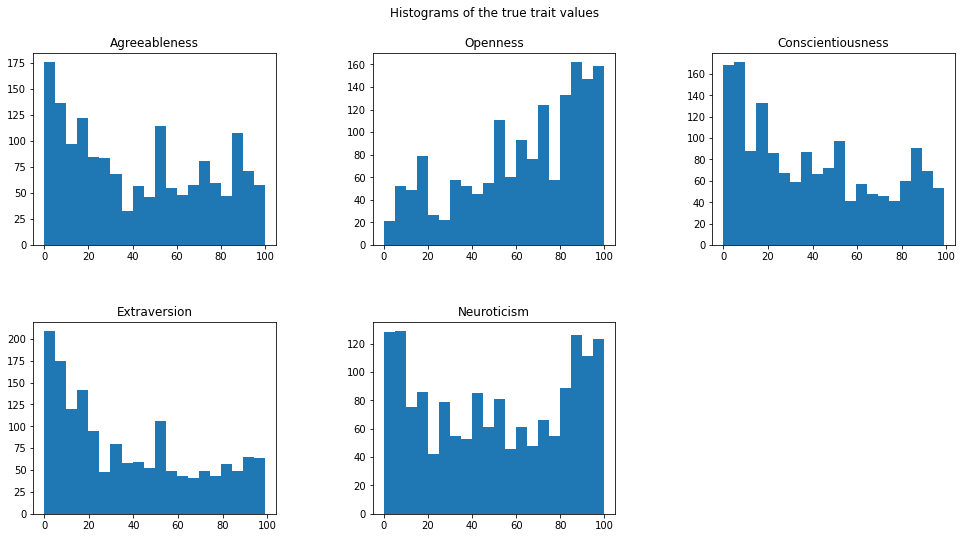

Trait to predict:  agree
Number of authors in y_train:  1204
Number of authors in y_test:  402


/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/feature_selection/_variance_threshold.py:78: RuntimeWarning: Degrees of freedom <= 0 for slice.
  self.variances_ = np.nanvar(X, axis=0)
/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/feature_selection/_variance_threshold.py:86: RuntimeWarning: All-NaN slice encountered
  self.variances_ = np.nanmin(compare_arr, axis=0)


Number of authors in y_pred:  402
Names of the top 30 features: 
 Index(['aram', 'xntxpolitics', 'cursedcomments', 'healthanxiety', 'brainmemes',
       'legendsoftomorrow', 'hmusfederalists', 'mhoclabourpress', 'jhu',
       'donaldglover', 'designerreps', 'berlindnd', 'meup', 'notthebeaverton',
       'ironfistnetflix', 'cern', 'celebsbr', 'beer', 'toukiden',
       'youtubemusic', 'wgtow', 'printsf', 'dopplebangher', 'boobbounce',
       'bedroombands', 'penismeasured', 'delaware4sanders', 'wacom', 'dmb',
       'latestagecapitalism'],
      dtype='object') 



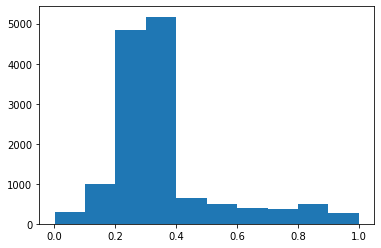


P-Values: 
                     Specs     Score   P-Value
13970  latestagecapitalism  9.982550  0.001620
12571         bedroombands  7.169407  0.007517
7869          donaldglover  6.555185  0.010579
12091           boobbounce  6.533546  0.010708
12952                wacom  6.046396  0.014075
1049                  aram  5.872649  0.015525
10931                wgtow  5.838468  0.015828
6512       mhoclabourpress  5.763579  0.016513
11685        dopplebangher  5.545219  0.018691
8302             berlindnd  5.533585  0.018815
4111       hmusfederalists  5.489000  0.019299
2927            brainmemes  5.448194  0.019753
12693        penismeasured  5.441751  0.019825
3138     legendsoftomorrow  5.441411  0.019829
6534                   jhu  5.352320  0.020863
8733                  meup  5.304787  0.021437
10498         youtubemusic  5.302221  0.021468
9925                  beer  5.283944  0.021694
10397             toukiden  5.222080  0.022475
9228                  cern  5.216711  0.022545
8

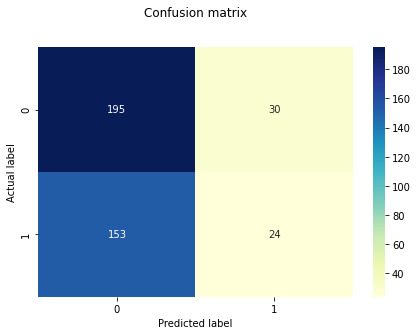

Classification report: 
               precision    recall  f1-score   support

           0       0.56      0.87      0.68       225
           1       0.44      0.14      0.21       177

    accuracy                           0.54       402
   macro avg       0.50      0.50      0.44       402
weighted avg       0.51      0.54      0.47       402



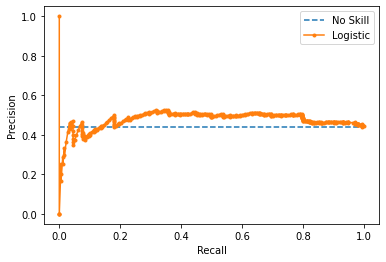


 
 

Trait to predict:  openn
Number of authors in y_train:  1204
Number of authors in y_test:  402


/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/feature_selection/_variance_threshold.py:78: RuntimeWarning: Degrees of freedom <= 0 for slice.
  self.variances_ = np.nanvar(X, axis=0)
/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/feature_selection/_variance_threshold.py:86: RuntimeWarning: All-NaN slice encountered
  self.variances_ = np.nanmin(compare_arr, axis=0)


Number of authors in y_pred:  402
Names of the top 30 features: 
 Index(['taylorswiftbum', 'colonizemars', 'takeonestepforward',
       'incelsgonewild', 'xsomalian', 'choose_your_own', 'calmdown',
       'pharahmains', 'polyglot', 'scratch', 'techno', 'manyatruenerd',
       'youshouldknow', 'pussymound', 'pipetobacco', 'perfect_response', 'npc',
       'winnipeg', 'nightwish', 'minecraftcirclejerk', 'lcdsoundsystem', 'msu',
       'upvoteexeggutor', 'wrangler', 'progressivegrowth', 'oldbritishtelly',
       'shinee', 'northeastlowercourt', 'williamshatner', 'tolkienbooks'],
      dtype='object') 



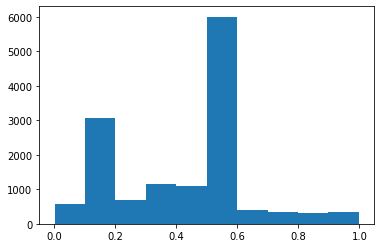


P-Values: 
                     Specs     Score   P-Value
4935                techno  9.659142  0.001928
8319      perfect_response  9.639169  0.001949
12537  northeastlowercourt  9.427850  0.002185
3022              calmdown  9.158709  0.002528
9337             nightwish  8.575046  0.003472
10687             wrangler  7.871853  0.005102
11938      oldbritishtelly  7.801908  0.005302
4992         manyatruenerd  7.646012  0.005777
10642      upvoteexeggutor  7.629649  0.005829
11857    progressivegrowth  7.522377  0.006184
2892       choose_your_own  7.481371  0.006326
393         taylorswiftbum  7.293282  0.007019
9987   minecraftcirclejerk  7.223776  0.007294
10152       lcdsoundsystem  7.223776  0.007294
12256               shinee  7.223776  0.007294
7691           pipetobacco  7.108693  0.007774
1877             xsomalian  6.936285  0.008555
5861            pussymound  6.803706  0.009210
5195         youshouldknow  6.757012  0.009452
4863               scratch  6.747558  0.009502
1

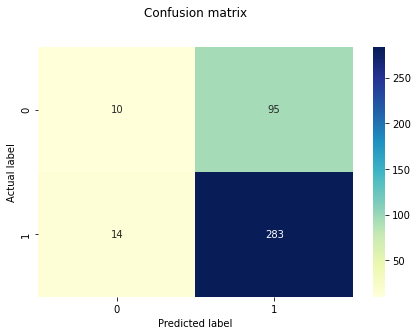

Classification report: 
               precision    recall  f1-score   support

           0       0.42      0.10      0.16       105
           1       0.75      0.95      0.84       297

    accuracy                           0.73       402
   macro avg       0.58      0.52      0.50       402
weighted avg       0.66      0.73      0.66       402



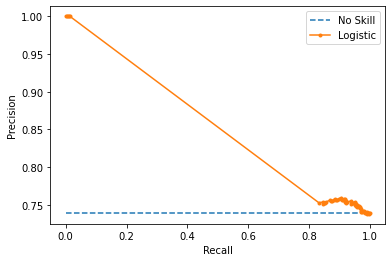


 
 

Trait to predict:  consc
Number of authors in y_train:  1204
Number of authors in y_test:  402


/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/feature_selection/_variance_threshold.py:78: RuntimeWarning: Degrees of freedom <= 0 for slice.
  self.variances_ = np.nanvar(X, axis=0)
/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/feature_selection/_variance_threshold.py:86: RuntimeWarning: All-NaN slice encountered
  self.variances_ = np.nanmin(compare_arr, axis=0)


Number of authors in y_pred:  402
Names of the top 30 features: 
 Index(['friday', 'march', 'june', 'november', '2017', 'cyberdom',
       'tuckedinkitties', 'anno', 'astro_kpop', 'tfc', 'bimbofetish', 'ecchi',
       'roadporn', 'roastmeta', 'kansascity', 'warframerunway', 'nova',
       'allthingsmlg', 'floridaman', 'oliverfrancis', 'motog', 'funaskreddit',
       'notthebeaverton', 'intp_void', 'chords', 'thaumcraft',
       'technoproduction', 'penismeasured', 'goldlittlefinger', 'burningman'],
      dtype='object') 



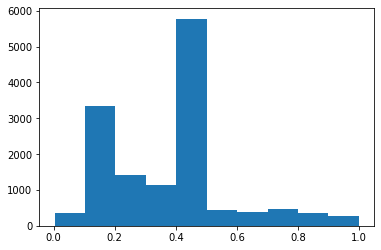


P-Values: 
                  Specs     Score   P-Value
8275              motog  9.064489  0.002661
2610              ecchi  7.241114  0.007224
2235                tfc  7.053449  0.008016
1537               anno  6.898780  0.008735
12693     penismeasured  6.623317  0.010184
13968        burningman  6.577558  0.010448
14                 june  6.520094  0.010789
4262     warframerunway  6.192990  0.012960
2828           roadporn  6.064801  0.013930
3066          roastmeta  6.054158  0.014013
7765      oliverfrancis  6.041811  0.014111
6386       allthingsmlg  5.869956  0.015548
11936  technoproduction  5.635903  0.017753
1614         astro_kpop  5.510122  0.019068
10161         intp_void  5.374429  0.020601
11439        thaumcraft  5.350136  0.020889
6                friday  5.342406  0.020981
8756    notthebeaverton  5.247861  0.022146
8345       funaskreddit  5.195648  0.022818
5470               nova  5.176906  0.023064
2285        bimbofetish  5.079786  0.024386
6600         florida

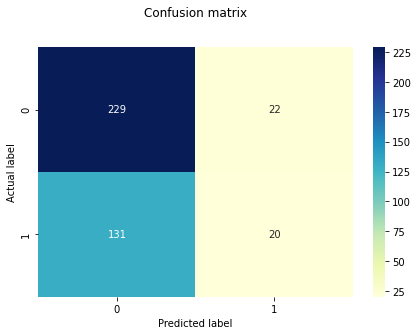

Classification report: 
               precision    recall  f1-score   support

           0       0.64      0.91      0.75       251
           1       0.48      0.13      0.21       151

    accuracy                           0.62       402
   macro avg       0.56      0.52      0.48       402
weighted avg       0.58      0.62      0.55       402



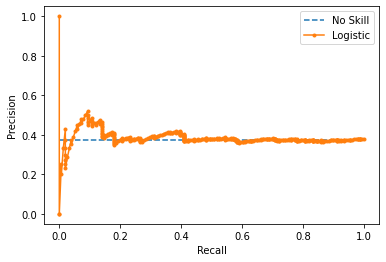


 
 

Trait to predict:  extra
Number of authors in y_train:  1204
Number of authors in y_test:  402


/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/feature_selection/_variance_threshold.py:78: RuntimeWarning: Degrees of freedom <= 0 for slice.
  self.variances_ = np.nanvar(X, axis=0)
/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/feature_selection/_variance_threshold.py:86: RuntimeWarning: All-NaN slice encountered
  self.variances_ = np.nanmin(compare_arr, axis=0)


Number of authors in y_pred:  402
Names of the top 30 features: 
 Index(['aram', 'astro_kpop', 'politicsnow', 'goldenkamuy', 'theexaminedlife',
       '300yearsago', 'newgirl', 'stretched', 'learncsharp', 'studioone',
       'pokememes', 'birthday', 'bigtiddygothgf', 'mepl', 'christianr4r',
       'ridiebridie', 'ableton', 'oopsdidntmeanto', 'motog', 'psych_religion',
       'ubc', 'draintheswamp', 'fcdallas', 'germanstorytime',
       'thedivision_lfg', 'vikings_tvseries', 'asoue', 'boobbounce', 'twice',
       'oilpen'],
      dtype='object') 



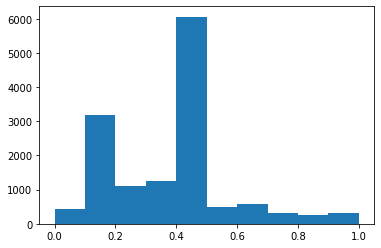


P-Values: 
                  Specs      Score   P-Value
9750    thedivision_lfg  17.873165  0.000025
4419               mepl  10.825511  0.001030
8166    oopsdidntmeanto  10.604242  0.001160
12091        boobbounce   8.724362  0.003201
8275              motog   8.673804  0.003290
8617     psych_religion   8.141577  0.004400
2688            newgirl   7.879252  0.005081
3229          pokememes   7.389130  0.006656
1614         astro_kpop   7.146599  0.007612
7414            ableton   6.981127  0.008344
4451       christianr4r   6.944239  0.008517
1049               aram   6.917551  0.008644
2475    theexaminedlife   6.808326  0.009186
2945        learncsharp   6.590729  0.010371
11272             asoue   6.342668  0.011916
9847   vikings_tvseries   6.281404  0.012332
2161        goldenkamuy   6.227581  0.012711
13129            oilpen   5.916581  0.015144
5797        ridiebridie   5.916293  0.015147
9697    germanstorytime   5.644183  0.017669
9356      draintheswamp   5.627994  0.01783

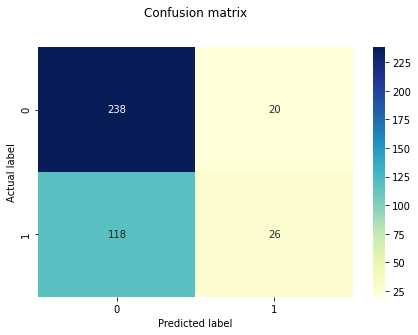

Classification report: 
               precision    recall  f1-score   support

           0       0.67      0.92      0.78       258
           1       0.57      0.18      0.27       144

    accuracy                           0.66       402
   macro avg       0.62      0.55      0.52       402
weighted avg       0.63      0.66      0.60       402



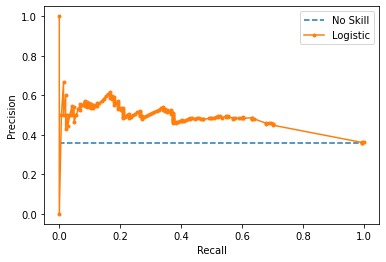


 
 

Trait to predict:  neuro
Number of authors in y_train:  1204
Number of authors in y_test:  402


/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/feature_selection/_variance_threshold.py:78: RuntimeWarning: Degrees of freedom <= 0 for slice.
  self.variances_ = np.nanvar(X, axis=0)
/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/feature_selection/_variance_threshold.py:86: RuntimeWarning: All-NaN slice encountered
  self.variances_ = np.nanmin(compare_arr, axis=0)


Number of authors in y_pred:  402
Names of the top 30 features: 
 Index(['hammer', 'onetruetohsaka', 'rightwinguk', 'smallpenisproblems', '5htp',
       'actuary', 'g59', 'dae', 'intpmusic', 'm43', 'thegoodplace', 'gog',
       'amumumains', 'mammothmountain', 'dsp', 'riseupp', 'bacon',
       'thegreatwarchannel', 'iconsgg', 'writingcirclejerk',
       'asianparentstories', 'pokemongonova', 'ehm', 'skyrimjourney',
       'starwarsrebels', 'mctv', 'amifat', 'puremathematics', '52in52',
       'vexillology'],
      dtype='object') 



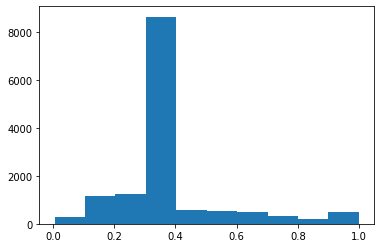


P-Values: 
                    Specs     Score   P-Value
1902   smallpenisproblems  7.782986  0.005357
7584                  gog  6.298435  0.012215
13969         vexillology  6.126410  0.013455
3126              actuary  6.100193  0.013655
13966              52in52  5.835265  0.015856
414           rightwinguk  5.825633  0.015943
4163                  dae  5.596743  0.018152
11653       pokemongonova  5.592188  0.018199
10178  thegreatwarchannel  5.538586  0.018762
13289                mctv  5.342305  0.020982
10767  asianparentstories  5.312014  0.021349
7609           amumumains  5.260754  0.021983
8989              riseupp  5.243902  0.022196
10473             iconsgg  5.173415  0.023111
9175                bacon  5.087755  0.024275
12241       skyrimjourney  4.984573  0.025758
11948                 ehm  4.869220  0.027528
8982                  dsp  4.854575  0.027762
6907         thegoodplace  4.825754  0.028228
13889     puremathematics  4.754735  0.029411
13504              ami

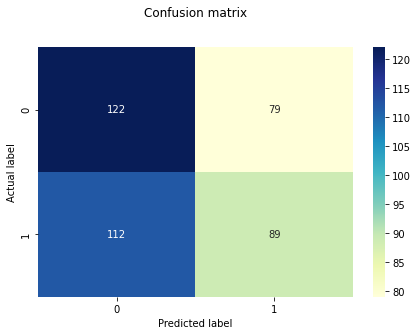

Classification report: 
               precision    recall  f1-score   support

           0       0.52      0.61      0.56       201
           1       0.53      0.44      0.48       201

    accuracy                           0.52       402
   macro avg       0.53      0.52      0.52       402
weighted avg       0.53      0.52      0.52       402



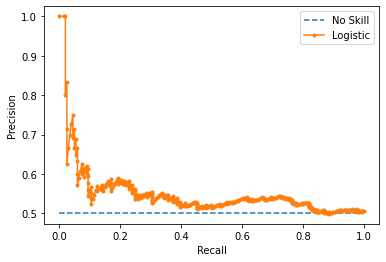

In [34]:
start = 18
print ("Number of authors: ", len(psychdf))

# personality prediction on test set
all_hist_true(psychdf)
classify(psychdf, "agree", start, plotting=True)
classify(psychdf, "openn", start, plotting=True)
classify(psychdf, "consc", start, plotting=True)
classify(psychdf, "extra", start, plotting=True)
classify(psychdf, "neuro", start, plotting=True)

In [35]:
# Results for the train set

def classify_trainset(df, trait_name, startnumber, plotting=True):
    print("Trait to predict: ", trait_name)
    x,y = trait(df, trait_name, startnumber)
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=0)
    logpipe = create_pipeline(x_train, y_train, 'log')
    y_pred=logpipe.predict(x_train)
    print("Number of authors in y_pred: ", len(y_pred))
    names = get_names(x, logpipe)
    print("Names of the top", len(names), "features: \n", names, "\n")
    pvalues = get_pvalues(logpipe, x)
#     print("p-values of", len(pvalues), "features: \n", pvalues, "\n")
    print("\nP-Values: ")
    print(pvalues.nsmallest(30,'P-Value'))
    print("\n")
    cnfmatrix = create_cnfmatrix(y_train, y_pred, plotting=True) 
#     accuracy, precision, recall, f_one = scores(y_test, y_pred, "scores")
#     print("Scores:\nAccuracy:",accuracy, "\nPrecision:",precision, "\nRecall:",recall, "\nF1 score:",f_one)
    report = scores(y_train, y_pred, "report")
    print("Classification report: \n", report)
    lr_precision, lr_recall = score_plot(logpipe, y_train, x_train)
#     print("Scores:\nLR_Precision:",lr_precision, "\nLR_Recall:",lr_recall)
    plt.show()
    print("\n \n")

Trait to predict:  agree


/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/feature_selection/_variance_threshold.py:78: RuntimeWarning: Degrees of freedom <= 0 for slice.
  self.variances_ = np.nanvar(X, axis=0)
/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/feature_selection/_variance_threshold.py:86: RuntimeWarning: All-NaN slice encountered
  self.variances_ = np.nanmin(compare_arr, axis=0)


Number of authors in y_pred:  1204
Names of the top 30 features: 
 Index(['aram', 'xntxpolitics', 'cursedcomments', 'healthanxiety', 'brainmemes',
       'legendsoftomorrow', 'hmusfederalists', 'mhoclabourpress', 'jhu',
       'donaldglover', 'designerreps', 'berlindnd', 'meup', 'notthebeaverton',
       'ironfistnetflix', 'cern', 'celebsbr', 'beer', 'toukiden',
       'youtubemusic', 'wgtow', 'printsf', 'dopplebangher', 'boobbounce',
       'bedroombands', 'penismeasured', 'delaware4sanders', 'wacom', 'dmb',
       'latestagecapitalism'],
      dtype='object') 



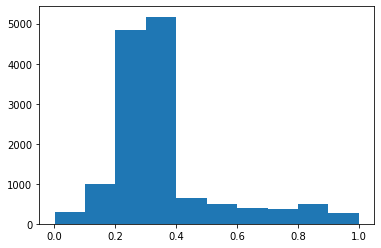


P-Values: 
                     Specs     Score   P-Value
13970  latestagecapitalism  9.982550  0.001620
12571         bedroombands  7.169407  0.007517
7869          donaldglover  6.555185  0.010579
12091           boobbounce  6.533546  0.010708
12952                wacom  6.046396  0.014075
1049                  aram  5.872649  0.015525
10931                wgtow  5.838468  0.015828
6512       mhoclabourpress  5.763579  0.016513
11685        dopplebangher  5.545219  0.018691
8302             berlindnd  5.533585  0.018815
4111       hmusfederalists  5.489000  0.019299
2927            brainmemes  5.448194  0.019753
12693        penismeasured  5.441751  0.019825
3138     legendsoftomorrow  5.441411  0.019829
6534                   jhu  5.352320  0.020863
8733                  meup  5.304787  0.021437
10498         youtubemusic  5.302221  0.021468
9925                  beer  5.283944  0.021694
10397             toukiden  5.222080  0.022475
9228                  cern  5.216711  0.022545
8

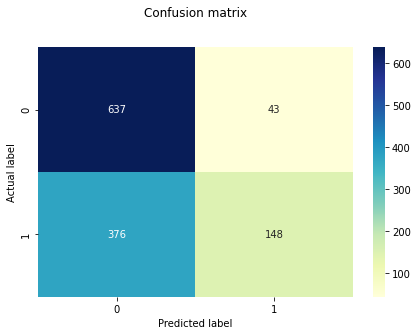

Classification report: 
               precision    recall  f1-score   support

           0       0.63      0.94      0.75       680
           1       0.77      0.28      0.41       524

    accuracy                           0.65      1204
   macro avg       0.70      0.61      0.58      1204
weighted avg       0.69      0.65      0.61      1204



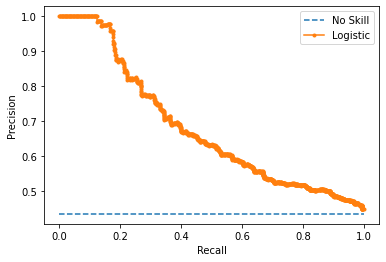


 

Trait to predict:  openn


/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/feature_selection/_variance_threshold.py:78: RuntimeWarning: Degrees of freedom <= 0 for slice.
  self.variances_ = np.nanvar(X, axis=0)
/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/feature_selection/_variance_threshold.py:86: RuntimeWarning: All-NaN slice encountered
  self.variances_ = np.nanmin(compare_arr, axis=0)


Number of authors in y_pred:  1204
Names of the top 30 features: 
 Index(['taylorswiftbum', 'colonizemars', 'takeonestepforward',
       'incelsgonewild', 'xsomalian', 'choose_your_own', 'calmdown',
       'pharahmains', 'polyglot', 'scratch', 'techno', 'manyatruenerd',
       'youshouldknow', 'pussymound', 'pipetobacco', 'perfect_response', 'npc',
       'winnipeg', 'nightwish', 'minecraftcirclejerk', 'lcdsoundsystem', 'msu',
       'upvoteexeggutor', 'wrangler', 'progressivegrowth', 'oldbritishtelly',
       'shinee', 'northeastlowercourt', 'williamshatner', 'tolkienbooks'],
      dtype='object') 



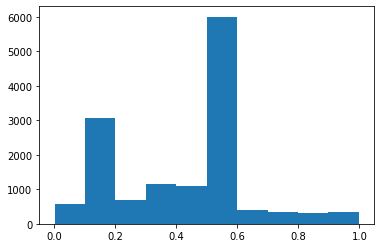


P-Values: 
                     Specs     Score   P-Value
4935                techno  9.659142  0.001928
8319      perfect_response  9.639169  0.001949
12537  northeastlowercourt  9.427850  0.002185
3022              calmdown  9.158709  0.002528
9337             nightwish  8.575046  0.003472
10687             wrangler  7.871853  0.005102
11938      oldbritishtelly  7.801908  0.005302
4992         manyatruenerd  7.646012  0.005777
10642      upvoteexeggutor  7.629649  0.005829
11857    progressivegrowth  7.522377  0.006184
2892       choose_your_own  7.481371  0.006326
393         taylorswiftbum  7.293282  0.007019
9987   minecraftcirclejerk  7.223776  0.007294
10152       lcdsoundsystem  7.223776  0.007294
12256               shinee  7.223776  0.007294
7691           pipetobacco  7.108693  0.007774
1877             xsomalian  6.936285  0.008555
5861            pussymound  6.803706  0.009210
5195         youshouldknow  6.757012  0.009452
4863               scratch  6.747558  0.009502
1

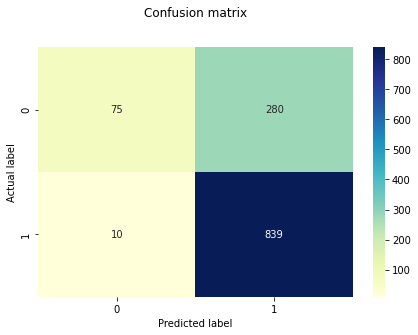

Classification report: 
               precision    recall  f1-score   support

           0       0.88      0.21      0.34       355
           1       0.75      0.99      0.85       849

    accuracy                           0.76      1204
   macro avg       0.82      0.60      0.60      1204
weighted avg       0.79      0.76      0.70      1204



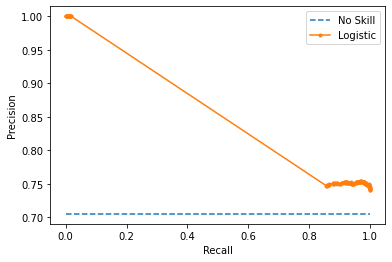


 

Trait to predict:  consc


/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/feature_selection/_variance_threshold.py:78: RuntimeWarning: Degrees of freedom <= 0 for slice.
  self.variances_ = np.nanvar(X, axis=0)
/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/feature_selection/_variance_threshold.py:86: RuntimeWarning: All-NaN slice encountered
  self.variances_ = np.nanmin(compare_arr, axis=0)


Number of authors in y_pred:  1204
Names of the top 30 features: 
 Index(['friday', 'march', 'june', 'november', '2017', 'cyberdom',
       'tuckedinkitties', 'anno', 'astro_kpop', 'tfc', 'bimbofetish', 'ecchi',
       'roadporn', 'roastmeta', 'kansascity', 'warframerunway', 'nova',
       'allthingsmlg', 'floridaman', 'oliverfrancis', 'motog', 'funaskreddit',
       'notthebeaverton', 'intp_void', 'chords', 'thaumcraft',
       'technoproduction', 'penismeasured', 'goldlittlefinger', 'burningman'],
      dtype='object') 



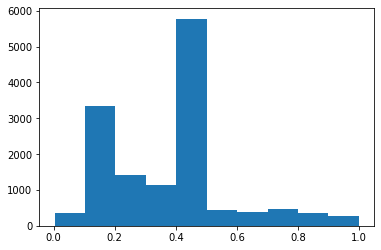


P-Values: 
                  Specs     Score   P-Value
8275              motog  9.064489  0.002661
2610              ecchi  7.241114  0.007224
2235                tfc  7.053449  0.008016
1537               anno  6.898780  0.008735
12693     penismeasured  6.623317  0.010184
13968        burningman  6.577558  0.010448
14                 june  6.520094  0.010789
4262     warframerunway  6.192990  0.012960
2828           roadporn  6.064801  0.013930
3066          roastmeta  6.054158  0.014013
7765      oliverfrancis  6.041811  0.014111
6386       allthingsmlg  5.869956  0.015548
11936  technoproduction  5.635903  0.017753
1614         astro_kpop  5.510122  0.019068
10161         intp_void  5.374429  0.020601
11439        thaumcraft  5.350136  0.020889
6                friday  5.342406  0.020981
8756    notthebeaverton  5.247861  0.022146
8345       funaskreddit  5.195648  0.022818
5470               nova  5.176906  0.023064
2285        bimbofetish  5.079786  0.024386
6600         florida

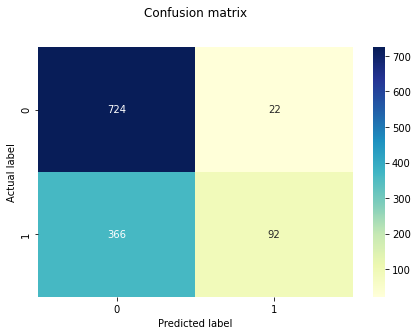

Classification report: 
               precision    recall  f1-score   support

           0       0.66      0.97      0.79       746
           1       0.81      0.20      0.32       458

    accuracy                           0.68      1204
   macro avg       0.74      0.59      0.56      1204
weighted avg       0.72      0.68      0.61      1204



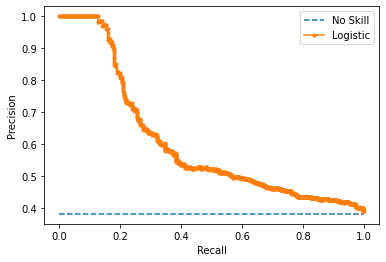


 

Trait to predict:  extra


/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/feature_selection/_variance_threshold.py:78: RuntimeWarning: Degrees of freedom <= 0 for slice.
  self.variances_ = np.nanvar(X, axis=0)
/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/feature_selection/_variance_threshold.py:86: RuntimeWarning: All-NaN slice encountered
  self.variances_ = np.nanmin(compare_arr, axis=0)


Number of authors in y_pred:  1204
Names of the top 30 features: 
 Index(['aram', 'astro_kpop', 'politicsnow', 'goldenkamuy', 'theexaminedlife',
       '300yearsago', 'newgirl', 'stretched', 'learncsharp', 'studioone',
       'pokememes', 'birthday', 'bigtiddygothgf', 'mepl', 'christianr4r',
       'ridiebridie', 'ableton', 'oopsdidntmeanto', 'motog', 'psych_religion',
       'ubc', 'draintheswamp', 'fcdallas', 'germanstorytime',
       'thedivision_lfg', 'vikings_tvseries', 'asoue', 'boobbounce', 'twice',
       'oilpen'],
      dtype='object') 



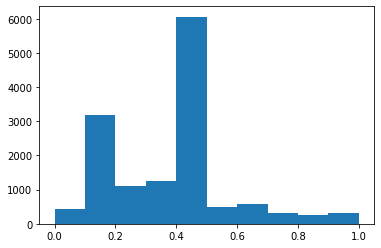


P-Values: 
                  Specs      Score   P-Value
9750    thedivision_lfg  17.873165  0.000025
4419               mepl  10.825511  0.001030
8166    oopsdidntmeanto  10.604242  0.001160
12091        boobbounce   8.724362  0.003201
8275              motog   8.673804  0.003290
8617     psych_religion   8.141577  0.004400
2688            newgirl   7.879252  0.005081
3229          pokememes   7.389130  0.006656
1614         astro_kpop   7.146599  0.007612
7414            ableton   6.981127  0.008344
4451       christianr4r   6.944239  0.008517
1049               aram   6.917551  0.008644
2475    theexaminedlife   6.808326  0.009186
2945        learncsharp   6.590729  0.010371
11272             asoue   6.342668  0.011916
9847   vikings_tvseries   6.281404  0.012332
2161        goldenkamuy   6.227581  0.012711
13129            oilpen   5.916581  0.015144
5797        ridiebridie   5.916293  0.015147
9697    germanstorytime   5.644183  0.017669
9356      draintheswamp   5.627994  0.01783

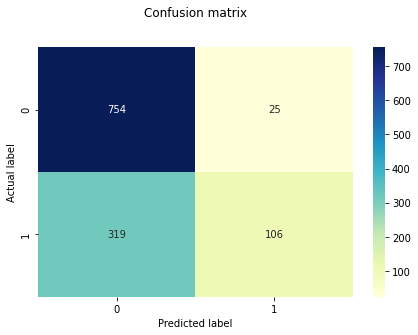

Classification report: 
               precision    recall  f1-score   support

           0       0.70      0.97      0.81       779
           1       0.81      0.25      0.38       425

    accuracy                           0.71      1204
   macro avg       0.76      0.61      0.60      1204
weighted avg       0.74      0.71      0.66      1204



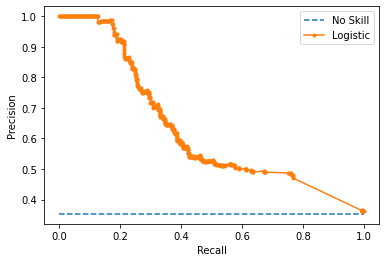


 

Trait to predict:  neuro


/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/feature_selection/_variance_threshold.py:78: RuntimeWarning: Degrees of freedom <= 0 for slice.
  self.variances_ = np.nanvar(X, axis=0)
/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/feature_selection/_variance_threshold.py:86: RuntimeWarning: All-NaN slice encountered
  self.variances_ = np.nanmin(compare_arr, axis=0)


Number of authors in y_pred:  1204
Names of the top 30 features: 
 Index(['hammer', 'onetruetohsaka', 'rightwinguk', 'smallpenisproblems', '5htp',
       'actuary', 'g59', 'dae', 'intpmusic', 'm43', 'thegoodplace', 'gog',
       'amumumains', 'mammothmountain', 'dsp', 'riseupp', 'bacon',
       'thegreatwarchannel', 'iconsgg', 'writingcirclejerk',
       'asianparentstories', 'pokemongonova', 'ehm', 'skyrimjourney',
       'starwarsrebels', 'mctv', 'amifat', 'puremathematics', '52in52',
       'vexillology'],
      dtype='object') 



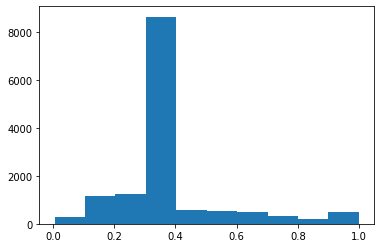


P-Values: 
                    Specs     Score   P-Value
1902   smallpenisproblems  7.782986  0.005357
7584                  gog  6.298435  0.012215
13969         vexillology  6.126410  0.013455
3126              actuary  6.100193  0.013655
13966              52in52  5.835265  0.015856
414           rightwinguk  5.825633  0.015943
4163                  dae  5.596743  0.018152
11653       pokemongonova  5.592188  0.018199
10178  thegreatwarchannel  5.538586  0.018762
13289                mctv  5.342305  0.020982
10767  asianparentstories  5.312014  0.021349
7609           amumumains  5.260754  0.021983
8989              riseupp  5.243902  0.022196
10473             iconsgg  5.173415  0.023111
9175                bacon  5.087755  0.024275
12241       skyrimjourney  4.984573  0.025758
11948                 ehm  4.869220  0.027528
8982                  dsp  4.854575  0.027762
6907         thegoodplace  4.825754  0.028228
13889     puremathematics  4.754735  0.029411
13504              ami

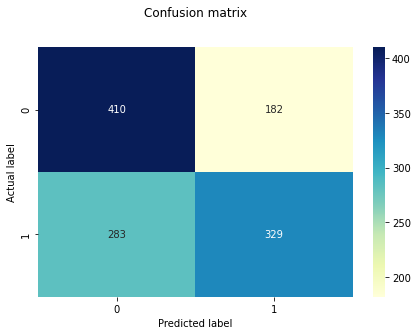

Classification report: 
               precision    recall  f1-score   support

           0       0.59      0.69      0.64       592
           1       0.64      0.54      0.59       612

    accuracy                           0.61      1204
   macro avg       0.62      0.62      0.61      1204
weighted avg       0.62      0.61      0.61      1204



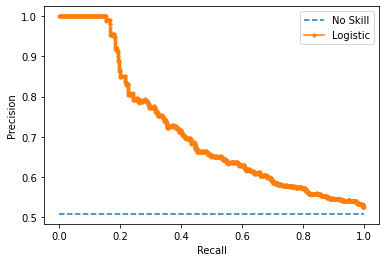

In [36]:
classify_trainset(psychdf, "agree", start, plotting=True)
classify_trainset(psychdf, "openn", start, plotting=True)
classify_trainset(psychdf, "consc", start, plotting=True)
classify_trainset(psychdf, "extra", start, plotting=True)
classify_trainset(psychdf, "neuro", start, plotting=True)